# Learning curves
## Week 4, group 4
Ivan Fernandez, Eirik Odinsen, Nadiia Piiter, Xu Qin, Magnus Windfeldt

# Agenda

- What are learning curves?  
- Why are they important?  
- Typical patterns in learning curves  
- Bias–Variance trade-off  
- How to interpret and use them


## What are learning curves?

It is a graphical representation that helps to understand the accuracy evolution in a model


- **Definition:** Plot model performance vs. **training set size** or **model complexity**.
- **x-axis:** number of training samples (or number of e.g. estimators)
- **y-axis:** one metric for model performance (e.g., Accuracy, \(R^2\), RMSE).
- **Two curves:** **Train** (fit & scored on train) and **Test** (held-out/CV).
- **Why care?** Diagnose **bias ↔ variance**, decide **more data vs. better model**, see **diminishing returns**.


![short alt text](https://www.dataquest.io/wp-content/uploads/2019/01/biasvariance.png)


# Why are learning curves important?

- Diagnose underfitting or overfitting  
- Check if training and testing data are representative  
- Show how performance changes as data increases  
- Guide whether to improve the model or add data
- Help choose best values for hyperparameters

***


## Bias–Variance trade-off
Quick refresher from the lecture:
- **Bias:** Error from simplifying assumptions (model too rigid).  
  *Example:* linear fit to nonlinear data → **underfit**.
- **Variance:** Error from sensitivity to the training sample (model too wiggly).  
  *Example:* memorizes noise → **overfit**.
- **Trade-off:** Reducing one often increases the other.
- **Irreducible noise:** Error you can’t remove.


## How to read a learning curve
**Typical patterns**
- **High bias (underfitting):** Train $\approx$ Test, both poor; curves flatten early.  
  ➜ Use richer model/features, **reduce regularization**.

- **High variance (overfitting):** Train $\gg$ Test; gap persists.  
  ➜ **More data**, stronger regularization, simpler model, ensembling.
  
- **Data sufficiency:**  
  - If **Test** still improves at right edge → **more data helps**.  
  - If **both flat** → change model/featurization, not data.

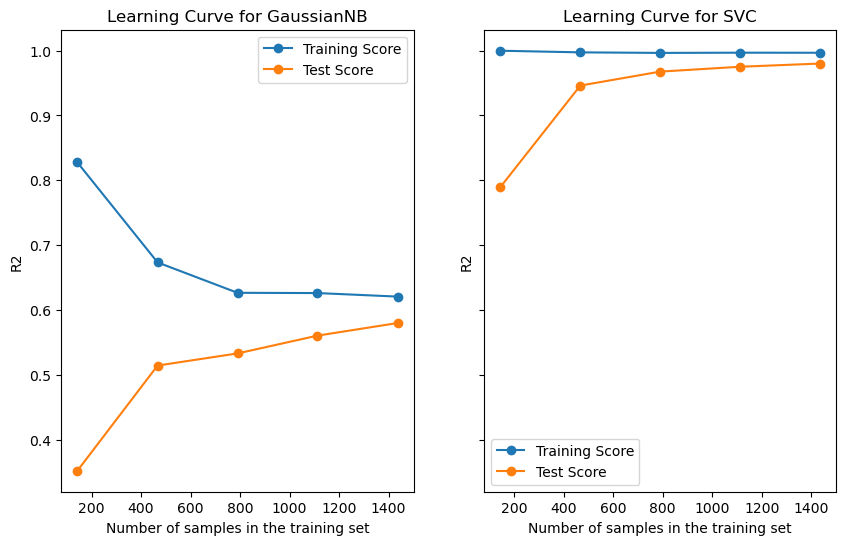

In [1]:
## Example from sklearn: 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

X_sk, y_sk = load_digits(return_X_y=True)
naive_bayes = GaussianNB()
svc = SVC(kernel="rbf", gamma=0.001)

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_sk,
    "y": y_sk,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": None,
    "score_name": "R2",
}

for ax_idx, estimator in enumerate([naive_bayes, svc]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx], scoring = "r2")
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

## How to calculate learning curve for my problem?

1. **Choose a metric** aligned to your goal (e.g., **RMSE** for regression).
2. **Pick a split strategy**
3. For a **grid of hyperparameter values**: fit on that subset; score on **train** and **test**.
4. **Plot Train vs. Test**; interpret **gap** and **slope**.

## Example:
Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope: a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age. 

![short alt text](https://www.manettas.com.au/wp-content/uploads/2023/11/image3-3.png)


In [2]:
# Some plotting functions
def plot_metric_custom(
    df,
    metric: str,
    ylabel: str,
    title: str,
    *,
    markersize: float = 6,
    show_line: bool = True,
    line_width: float = 1.5,
    show_trend: bool = False,
    trend_width: float = 2.0,
    show_trend_eq: bool = True,
    trend_npoints: int = 300,
    grid: bool = True
):
    """
    Plotea metric vs train_frac con opciones de:
    - tamaño de puntos
    - línea que une puntos (on/off + grosor)
    - línea de tendencia cuadrática (on/off + grosor)

    Parámetros clave:
      df: DataFrame con columnas ["train_frac", metric]
      metric: nombre de la columna de métrica, p.ej. "rmse"
      
      markersize: tamaño de los marcadores
      show_line: si True, une puntos con línea
      line_width: grosor de la línea de puntos
      show_trend: si True, añade ajuste cuadrático
      trend_width: grosor de la curva de tendencia
      show_trend_eq: si True, muestra ecuación y R² en la gráfica
    """
    x = df["train_frac"].to_numpy()
    y = df[metric].to_numpy()

    fig = plt.figure(figsize=(7, 5))

    # Dispersión (puntos)
    plt.scatter(x, y, s=markersize**2, label=metric.upper())  # markersize al cuadrado (área)

    # Línea que une los puntos (opcional)
    if show_line:
        plt.plot(x, y, linewidth=line_width, alpha=0.8)

    # Tendencia cuadrática (opcional)
    if show_trend and len(x) >= 3:
        # Ajuste polinómico de grado 2
        coeffs = np.polyfit(x, y, deg=2)
        p = np.poly1d(coeffs)

        # Curva suave
        xfit = np.linspace(x.min(), x.max(), trend_npoints)
        yfit = p(xfit)
        plt.plot(xfit, yfit, linewidth=trend_width, linestyle="-", color = "red", label="Tendencia (grado 2)")

        if show_trend_eq:
            # R^2 del ajuste
            y_pred = p(x)
            ss_res = np.sum((y - y_pred)**2)
            ss_tot = np.sum((y - y.mean())**2)
            r2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

            a, b, c = coeffs  # y = a x^2 + b x + c
            eq = f"y = {a:.3g}·x² + {b:.3g}·x + {c:.3g}\nR² = {r2:.3f}"
            # Cuadro de texto
            plt.gca().text(
                0.02, 0.98, eq,
                transform=plt.gca().transAxes,
                va="top", ha="left",
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
                fontsize=9
            )

    plt.xlabel("Train fraction (pu)")
    plt.ylabel(ylabel)
    plt.title(title)
    if grid:
        plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()


def plot_metric_train_vs_test(
    df, metric: str, ylabel: str, title: str,
    show_line: bool = True, line_width: float = 1.5, markersize: float = 5
):
    x = df["train_frac"].to_numpy()
    y_tr = df[f"train_{metric}"].to_numpy()
    y_te = df[f"test_{metric}"].to_numpy()

    plt.figure(figsize=(7,5))
    plt.scatter(x, y_tr, s=markersize**2, label=f"Train {metric.upper()}")
    plt.scatter(x, y_te, s=markersize**2, label=f"Test {metric.upper()}")

    if show_line:
        plt.plot(x, y_tr, linewidth=line_width)
        plt.plot(x, y_te, linewidth=line_width)

    plt.xlabel("Train fraction (pu)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()


In [3]:
# Dataset
# --- Imports & settings
import warnings
warnings.filterwarnings("ignore")  # silence warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score,
)

from xgboost import XGBRegressor

# Load Abalone
abalone = fetch_ucirepo(id=1)
X = abalone.data.features.copy()
y = abalone.data.targets["Rings"].astype(float).values  # age proxy

display(X,abalone.data.targets)
# Keep only numerical features
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X_num = X[num_cols].to_numpy(dtype=float)

# Base hyperparameters (we will vary n_estimators only)
xgb_base = dict(
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    seed=40,
    verbosity=0,
)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


,Rings
0,15
1,7
2,9
3,10
4,7
...,...
4172,11
4173,10
4174,9
4175,10


In [4]:
# Compute metrics
def compute_metrics(y_true, y_pred):
    return {
        "rmse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "median_ae": median_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred),
    }

# Varying hyperparameter (number of estimators)
def run_config(X_tr, X_te, y_tr, y_te):
    n_estimators_grid = list(range(1, 200, 1))  # 50, 100, ..., 1000
    rows = []

    for n_est in n_estimators_grid:
        model = XGBRegressor(n_estimators=n_est, **xgb_base)
        model.fit(X_tr, y_tr)
    
        # Test metrics
        y_pred_te = model.predict(X_te)
        m_te = compute_metrics(y_te, y_pred_te)
    
        # Train metrics
        y_pred_tr = model.predict(X_tr)
        m_tr = compute_metrics(y_tr, y_pred_tr)
    
        rows.append({
            "n_estimators": n_est,
            **{f"test_{k}": v for k, v in m_te.items()},
            **{f"train_{k}": v for k, v in m_tr.items()},
        })
    
        # Verbose one-liner
        # print(f" - n_estimators={n_est:4d} | "
        #       f"Train RMSE={m_tr['rmse']:.3f}  Test RMSE={m_te['rmse']:.3f}  "
        #       f"Train R2={m_tr['r2']:.3f}  Test R2={m_te['r2']:.3f}")
    results = pd.DataFrame(rows).sort_values("n_estimators").reset_index(drop=True)
    # results.to_csv("abalone_xgb_train_test_metrics_vs_n_estimators.csv", index=False)
    # print("Saved: abalone_xgb_train_test_metrics_vs_n_estimators.csv")
    return results

# Varying train set size (choo choo)
def run_config_2(X_tr, X_te, y_tr, y_te, n_est):
    n_samples_grid = list(range(70, len(X_tr), 20))  # 50, 100, ..., 1000
    rows = []
    model = XGBRegressor(n_estimators=n_est, **xgb_base)

    for n_sam in n_samples_grid:     
        model.fit(X_tr[0:n_sam], y_tr[0:n_sam])
    
        # Test metrics
        y_pred_te = model.predict(X_te)
        m_te = compute_metrics(y_te, y_pred_te)
    
        # Train metrics
        y_pred_tr = model.predict(X_tr[0:n_sam])
        m_tr = compute_metrics(y_tr[0:n_sam], y_pred_tr)
    
        rows.append({
            "n_estimators": n_sam,
            **{f"test_{k}": v for k, v in m_te.items()},
            **{f"train_{k}": v for k, v in m_tr.items()},
        })
    
        # Verbose one-liner
        # print(f" - n_estimators={n_est:4d} | "
        #       f"Train RMSE={m_tr['rmse']:.3f}  Test RMSE={m_te['rmse']:.3f}  "
        #       f"Train R2={m_tr['r2']:.3f}  Test R2={m_te['r2']:.3f}")
    
    results = pd.DataFrame(rows).sort_values("n_estimators").reset_index(drop=True)
    # results.to_csv("abalone_xgb_train_test_metrics_vs_n_samples.csv", index=False)
    # print("Saved: abalone_xgb_train_test_metrics_vs_n_samples.csv")
    return results


# Plot helper: Train vs Test for a given metric
def plot_metric_train_vs_test_estimators(
    df, metric: str, ylabel: str, xlabel: str, title: str,
    show_line: bool = True, line_width: float = 1.5, markersize: float = 5,
    highlight_min: bool = True,  # <— new
):
    x = df["n_estimators"].to_numpy()
    y_tr = df[f"train_{metric}"].to_numpy()
    y_te = df[f"test_{metric}"].to_numpy()

    plt.figure(figsize=(7,5))
    plt.scatter(x, y_tr, s=markersize**2, label=f"Train {metric.upper()}")
    plt.scatter(x, y_te, s=markersize**2, label=f"Test {metric.upper()}")

    if show_line:
        plt.plot(x, y_tr, linewidth=line_width)
        plt.plot(x, y_te, linewidth=line_width)

    # --- NEW: highlight minimum test error
    if highlight_min and len(y_te) > 0:
        idx_min = int(np.nanargmin(y_te))      # first index of the minimum (ignores NaNs)
        x_min   = x[idx_min]
        y_min   = y_te[idx_min]

        # vertical line at the best n_estimators
        plt.axvline(x=x_min, color="red", linestyle="--", linewidth=1.8,
                    label=f"Min test @ {int(x_min)}")

        # annotation with value and n_estimators
        plt.annotate(
            f"min {metric}: {y_min:.3f}\n n_estimators={int(x_min)}",
            xy=(x_min, y_min),
            xytext=(6, 10), textcoords="offset points",
            ha="left", va="bottom",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.9),
            arrowprops=dict(arrowstyle="->", color="red", lw=1.2)
        )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()

    # Optional: return the min for further use
    return {"n_estimators_min": int(x_min), "metric_min": float(y_min)} if highlight_min else None

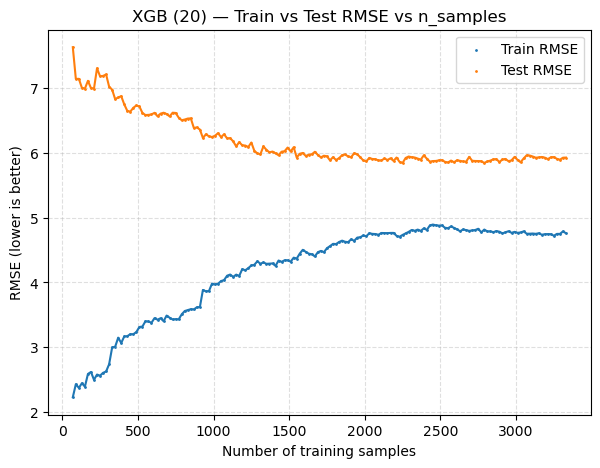

In [5]:
# Learning curve with 20 estimators
X_tr, X_te, y_tr, y_te = train_test_split(
    X_num, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=42
)
n_est = 20
results = run_config_2(X_tr, X_te, y_tr, y_te, n_est)
plot_metric_train_vs_test_estimators(
    results, "rmse", "RMSE (lower is better)", "Number of training samples", "XGB (20) — Train vs Test RMSE vs n_samples", markersize= 1,highlight_min=False
)

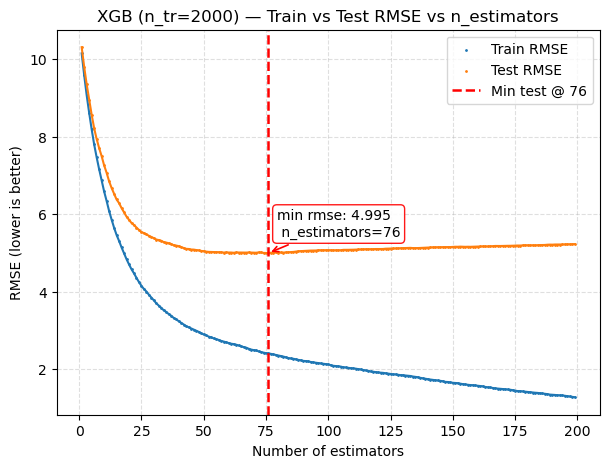

{'n_estimators_min': 76, 'metric_min': 4.995300369067898}

In [6]:
# Finding appropriate model complexity
#print("Running configurations (varying n_estimators, 80/20 split):")
results = run_config(X_tr[0:2000], X_te, y_tr[0:2000], y_te)
plot_metric_train_vs_test_estimators(
    results, "rmse", "RMSE (lower is better)", "Number of estimators", "XGB (n_tr=2000) — Train vs Test RMSE vs n_estimators", markersize= 1
)

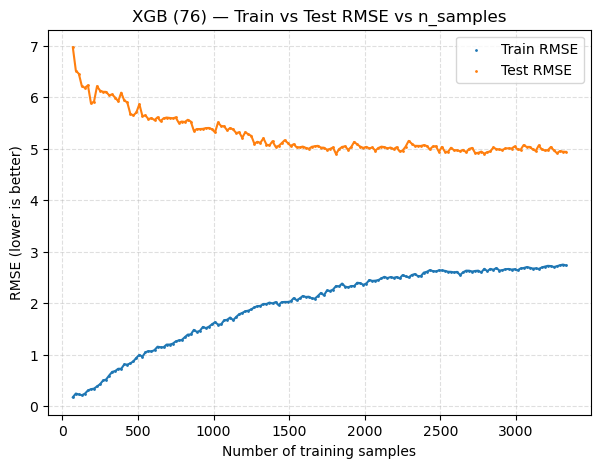

In [7]:
# Learning curve with 76 estimators
n_est = 76
results = run_config_2(X_tr, X_te, y_tr, y_te, n_est)
# --- 6) Plots
plot_metric_train_vs_test_estimators(
    results, "rmse", "RMSE (lower is better)", "Number of training samples", "XGB (76) — Train vs Test RMSE vs n_samples", markersize= 1,highlight_min=False
)

Running configurations (varying n_estimators, 50/50 split):


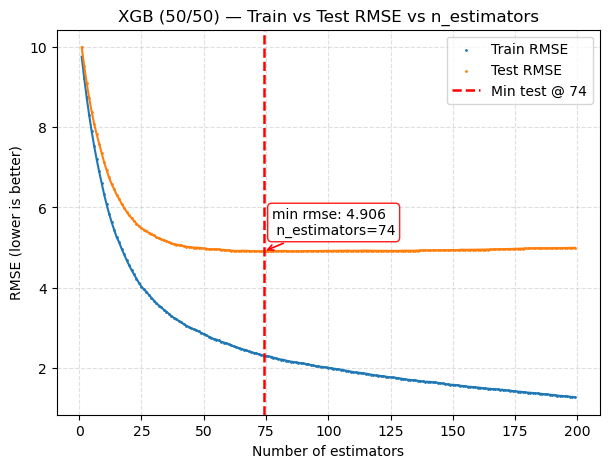

In [8]:
# Fixed 50/50 split 
X_tr, X_te, y_tr, y_te = train_test_split(
    X_num, y, train_size=0.5, test_size=0.5, shuffle=True, random_state=42
)

print("Running configurations (varying n_estimators, 50/50 split):")
results = run_config(X_tr, X_te, y_tr, y_te)
# --- 6) Plots
best = plot_metric_train_vs_test_estimators(
    results, "rmse", "RMSE (lower is better)", "Number of estimators", "XGB (50/50) — Train vs Test RMSE vs n_estimators", markersize= 1
)

Running configurations (varying n_estimators, 20/80 split):


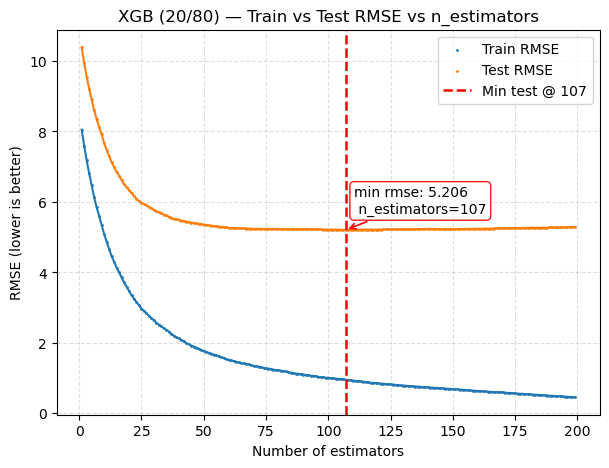

In [9]:
# --- 2) Fixed 20/80 split
X_tr, X_te, y_tr, y_te = train_test_split(
    X_num, y, train_size=0.2, test_size=0.8, shuffle=True, random_state=42
)
print("Running configurations (varying n_estimators, 20/80 split):")
results = run_config(X_tr, X_te, y_tr, y_te)
# --- 6) Plots
best = plot_metric_train_vs_test_estimators(
    results, "rmse", "RMSE (lower is better)", "Number of estimators", "XGB (20/80) — Train vs Test RMSE vs n_estimators", markersize= 1
)

Sweeping train fractions and n_estimators...


,train_frac,best_n_estimators,best_test_rmse
0,0.10,75,5.455835
1,0.15,79,5.238295
2,0.20,107,5.205652
3,0.25,84,5.037869
4,0.30,124,5.085566


,train_frac,best_n_estimators,best_test_rmse
13,0.75,65,4.645866
14,0.80,89,4.969567
15,0.85,140,4.706347
16,0.90,172,4.763099
17,0.95,184,5.153019


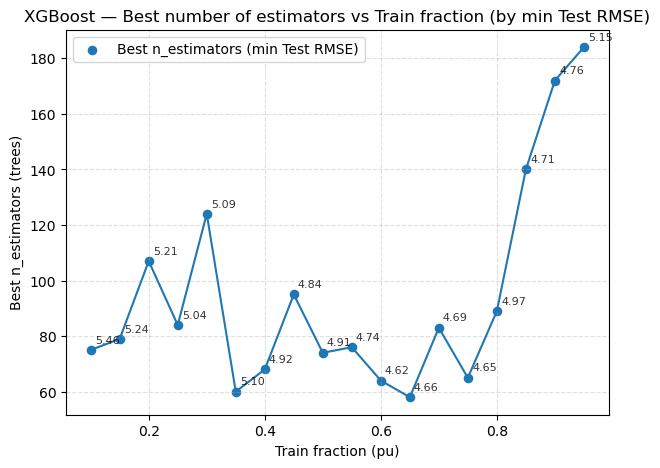

In [10]:
# Importance of data split
# Evaluate one model and return Test RMSE
def test_rmse(model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    return mean_squared_error(y_te, y_pred,)

# Grid definitions
n_estimators_grid = list(range(1, 200, 1))        # 1..199
train_fracs       = np.round(np.arange(0.10, 1.00, 0.05), 2)  # adjust as you like (0.10..0.95)

rows = []
print("Sweeping train fractions and n_estimators...")
for frac in train_fracs:
    # fixed shuffle seed per fraction for reproducibility
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_num, y, train_size=frac, test_size=1.0 - frac, shuffle=True, random_state=42
    )

    best_n = None
    best_err = np.inf

    # sweep n_estimators for this fraction
    for n_est in n_estimators_grid:
        model = XGBRegressor(n_estimators=n_est, **xgb_base)
        rmse = test_rmse(model, X_tr, y_tr, X_te, y_te)
        if rmse < best_err:
            best_err = rmse
            best_n   = n_est

    rows.append({"train_frac": float(frac), "best_n_estimators": int(best_n), "best_test_rmse": float(best_err)})
 #   print(f" - train_frac={frac:.2f}: best n_estimators={best_n:3d} | best Test RMSE={best_err:.3f}")

results = pd.DataFrame(rows).sort_values("train_frac").reset_index(drop=True)
results.to_csv("abalone_xgb_best_n_vs_train_frac.csv", index=False)
#print("Saved: abalone_xgb_best_n_vs_train_frac.csv")
display(results.head(), results.tail())

# Plot: x=train fraction, y=best n_estimators (annotate RMSE if you want)
plt.figure(figsize=(7,5))
plt.scatter(results["train_frac"], results["best_n_estimators"], s=35, label="Best n_estimators (min Test RMSE)")
plt.plot(results["train_frac"], results["best_n_estimators"], linewidth=1.5)

# optional: annotate each point with the best RMSE
for xf, nbest, err in results[["train_frac", "best_n_estimators", "best_test_rmse"]].itertuples(index=False):
    plt.annotate(f"{err:.2f}", (xf, nbest), textcoords="offset points", xytext=(3,5), fontsize=8, alpha=0.8)

plt.xlabel("Train fraction (pu)")
plt.ylabel("Best n_estimators (trees)")
plt.title("XGBoost — Best number of estimators vs Train fraction (by min Test RMSE)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.show()


## Alternatives & complements
- **Validation curves:** Score vs **one hyperparameter** (data size fixed).
- **Power-law fit:** $\text{error}(n) \approx a\,n^{-b} + c$ to **project data value**.
- **Gap plot:** Plot $\text{Train} - \text{Valid}$ vs data size.
- **Uncertainty bands:** Mean ± 1σ across folds to show stability.

# Learning Curves: Advantages & Disadvantages

| **Aspect** | **Advantages** | **Disadvantages** |
|------------|----------------|-------------------|
| **Interpretability** | - Very intuitive; easy to explain bias vs. variance.<br>- Clearly shows underfitting and overfitting patteons. | - May oversimplify; cannot capture all nuances.<br>- Interpretation sometimes ambiguous (data vs. model issues). |
| **Model Diagnosis** | - Helps decide whether to add more data or adjust model complexity.<br>- Can guide feature engineering and regularization choices.<br>- Supports fair model comparison. | - Requires repeated training; computationally expensive.<br>- Sensitive to dataset splitting strategy.<br>- Unstable with very small datasets. |
| **Practical Use** | - Guides resource allocation (e.g., when to stop collecting more data).<br>- Works across regression, classification, and unsupervised tasks.<br>- Provides both training and validation perspective. | - Cannot replace validation set for final evaluation.<br>- Needs careful metric selection to align with project goals.<br>- May require smoothing or averaging to reduce noise. |

**Key Takeaway**: Learning curves are a powerful and intuitive diagnostic tool for understanding bias–variance trade-offs and data sufficiency. They are easy to interpret but require setup and cannot replace independent validation sets.